In [396]:
from __future__ import division

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
sns.set_context('notebook', font_scale=1.3)
sns.set_style('whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [397]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import agent
import blockworld
import model

In [398]:
from utils import get_data
version = '1.4'
data = get_data(version, '../data')
df = data['blockworld']

# HACK
if version in ('1.2', '1.3'):
    df = data['blockworld'].set_index('pid', drop=False)
    pdf = data['participants'].set_index('pid')
    df['completed'] = pdf['completed']
    # HACK due to a bug with 1.2, we have to filter out subjects that are completed.
    df = df.query('completed')
    df = df.reset_index(drop=True)

# HACK due to an error where a participant restarted the task, we drop pid=10
if version == '1.3':
    df = df.loc[df.pid != 10]

if version == '1.4':
    bad_pids = []
    exp_rows = 35
    for pid, rows in df.groupby('pid'):
        if len(rows) == exp_rows:
            continue
        bad_pids.append(pid)
        print(f'Found bad pid {pid} with {len(rows)} problems, but expected {exp_rows}')
    print(f'Removing pids: {bad_pids}. Before {df.shape}')
    df = df.loc[~df.pid.isin(bad_pids)]
    print(f'After {df.shape}')

Found bad pid 5 with 45 problems, but expected 35
Found bad pid 26 with 32 problems, but expected 35
Removing pids: [5, 26]. Before (1722, 10)
After (1645, 10)


In [399]:
def parse_state(state):
    return tuple((tuple(filter(None, col.split(','))) 
                  for col in state.split(':')))

df.states = df.states.apply(lambda states: list(map(parse_state, states)))

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [400]:
# Cleaning erroneous data where some states are repeated.
# Totally strange, as we don't permit this in the UI... So we should also prohibit this in logic I think...
# TODO

for row_idx, row in df.iterrows():
    states = row.states

    result = []
    for idx, state in enumerate(states):
        if idx == 0 or state != states[idx-1]:
            result.append(state)
        else:
            print(f'Warning: For row {row_idx} pid {row.pid}, had to exclude repeated state at index {idx}.')

    if len(result) != len(row.states):
        df.at[row_idx, 'states'] = result

In [401]:
# How long did subjects take?

elapsed_df = []

all_min = []

for pid, pid_df in df.groupby('pid'):
    prev_row_elapsed = 0
    for _, row in pid_df.iterrows():
        elapsed_df.append(dict(
            pid=pid,
            duration_ms=row.time_elapsed - prev_row_elapsed,
            num_blocks=sum(len(col) for col in row.states[0]),
        ))
        prev_row_elapsed = row.time_elapsed

    minutes = prev_row_elapsed/1000/60
    #print(f'Total elapsed for pid {pid}: {minutes} minutes')

    all_min.append(minutes)

print(f'Mean time {np.mean(all_min):.02f} +- {np.std(all_min):.02f} minutes')
'''
elapsed_df = pd.DataFrame(elapsed_df)
elapsed_df['duration'] = elapsed_df['duration_ms'] / 1000

sns.boxplot(x='pid', y='duration', data=elapsed_df.loc[elapsed_df.num_blocks == 6])
plt.title('Duration for each 6-block problem')
plt.ylabel('Duration (seconds)')
plt.xlabel('Participant')
'''
None

Mean time 17.85 +- 6.15 minutes


In [402]:
df['num_actions'] = df['states'].apply(lambda s: len(s) - 1)
df['first_state'] = df['initial_state'] = df['states'].apply(lambda s: s[0])
df['num_blocks'] = df['initial_state'].apply(lambda initial: blockworld.Blockworld.count_blocks(initial))

df_to_analyze = df.query('num_blocks == 6')

if version in ('1.2', '1.3', '1.4'):

    num_trials = 32
    # HACK assuming that pids are in contiguous blocks
    df_to_analyze['trial_idx'] = np.tile(
        np.arange(num_trials),
        len(df_to_analyze.pid.unique()))

    df_to_analyze['trial_repeat'] = df_to_analyze['trial_idx'] >= num_trials/2

    # HACK let's flip everythin!!!
    df_to_analyze['states'] = df_to_analyze.apply(
        lambda row: [s[::-1] for s in row.states] if row.trial_repeat else row.states,
        axis=1)
    df_to_analyze['first_state'] = df_to_analyze['initial_state'] = df_to_analyze['states'].apply(lambda s: s[0])

    #df_to_analyze['true_orig'] = df_to_analyze.apply(
    #    lambda row: str(row.initial_state[::-1] if row.trial_repeat else row.initial_state), axis=1)
    df_to_analyze['true_orig'] = df_to_analyze['first_state'] # this is also now just the first state

    # Identify duplicate states & remove them.
    from collections import Counter
    all_starts = set(df_to_analyze.head(num_trials).initial_state.values)
    duplicate_states = {s for s in all_starts if s[::-1] in all_starts}
    print('# duplicate states', len(duplicate_states))
    print('before removing duplicates', df_to_analyze.shape)
    df_to_analyze = df_to_analyze.loc[~df_to_analyze.initial_state.isin(duplicate_states)]
    print('after removing duplicates', df_to_analyze.shape)


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

# duplicate states 0
before removing duplicates (1504, 17)
after removing duplicates (1504, 17)


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [403]:
def _add_actions_col(df):
    actions_col = []
    for _, row in df.iterrows():
        actions = [
            blockworld.compute_action_for_state_change(s, s_next)
            for s, s_next in zip(row.states[:-1], row.states[1:])
        ]
        assert len(actions) == len(row.states) - 1
        actions_col.append(actions)
    df['actions'] = actions_col
_add_actions_col(df_to_analyze)

In [404]:
df_to_analyze.head(3)

,high_stakes,initial_points,multiplier,no_bonus,points,states,time_elapsed,times,trial_type,pid,num_actions,first_state,initial_state,num_blocks,trial_idx,trial_repeat,true_orig,actions
3,False,0.0,0.0,True,0.0,"[((F, C, E), (A,), (D, B)), ((F, C, E, B), (A,...",189901,"[3448, 4913, 6616, 9522, 10640, 11813, 12681, ...",blockworld,17,17,"((F, C, E), (A,), (D, B))","((F, C, E), (A,), (D, B))",6,0,False,"((F, C, E), (A,), (D, B))","[(B, 0), (D, 0), (A, 0), (A, 2), (D, 2), (B, 2..."
4,False,0.0,0.0,True,0.0,"[((F, E, C), (B, A), (D,)), ((F, E, C), (B,), ...",209429,"[2124, 2890, 3806, 5296, 6526, 7308, 8762, 968...",blockworld,17,14,"((F, E, C), (B, A), (D,))","((F, E, C), (B, A), (D,))",6,1,False,"((F, E, C), (B, A), (D,))","[(A, 2), (C, 2), (E, 2), (B, 2), (F, 1), (B, 0..."
5,False,24.0,1.0,False,5.0,"[((F, B), (D, A, C, E), ()), ((F, B), (D, A, C...",235124,"[2512, 3341, 4036, 5038, 6473, 7678, 9044, 100...",blockworld,17,19,"((F, B), (D, A, C, E), ())","((F, B), (D, A, C, E), ())",6,2,False,"((F, B), (D, A, C, E), ())","[(E, 2), (C, 2), (A, 2), (D, 2), (B, 2), (F, 1..."


In [405]:
unique_problems = set([s[0] for s in df_to_analyze.states])
unique_problems_by_block = {}
for p in unique_problems:
    unique_problems_by_block.setdefault(blockworld.Blockworld.count_blocks(p), []).append(p)

problems_to_analyze = sorted(unique_problems_by_block[6])

# Sorting so that we can ensure things are more consistent and interpretable across re-runs.
problems_to_analyze = sorted(problems_to_analyze)
# We have 16 problems across all people
len(problems_to_analyze)

16

In [406]:
# Make a filtered df with problem_idx to simplify some things later on
df_to_analyze['problem_idx'] = df_to_analyze.first_state.apply(lambda s: problems_to_analyze.index(s))

print('Listing unique problems and their index.')
for idx, item in enumerate(problems_to_analyze):
    print(idx, item)

pid = 8
print('first five', np.array(problems_to_analyze)[df_to_analyze[df.pid==pid].problem_idx.values[:5]])
print('should start same as first five here:')
df_to_analyze[df.pid==pid].head(5)

Listing unique problems and their index.
0 ((), ('A', 'C', 'E', 'F'), ('D', 'B'))
1 (('E',), ('B',), ('F', 'C', 'D', 'A'))
2 (('E',), ('C',), ('F', 'B', 'A', 'D'))
3 (('E',), ('C', 'A', 'D'), ('F', 'B'))
4 (('E',), ('D', 'B', 'A', 'C'), ('F',))
5 (('E', 'B'), ('A', 'D'), ('F', 'C'))
6 (('E', 'D'), (), ('F', 'C', 'A', 'B'))
7 (('F',), ('B', 'D', 'A', 'C', 'E'), ())
8 (('F',), ('D', 'A', 'B', 'C'), ('E',))
9 (('F', 'B'), ('D', 'A', 'C', 'E'), ())
10 (('F', 'C', 'B', 'A'), (), ('D', 'E'))
11 (('F', 'C', 'E'), ('A',), ('D', 'B'))
12 (('F', 'D'), ('B', 'C'), ('E', 'A'))
13 (('F', 'E'), ('B', 'D', 'C', 'A'), ())
14 (('F', 'E', 'A'), ('B', 'C'), ('D',))
15 (('F', 'E', 'C'), ('B', 'A'), ('D',))
first five [[('F', 'C', 'E') ('A',) ('D', 'B')]
 [('F', 'E') ('B', 'D', 'C', 'A') ()]
 [('F', 'D') ('B', 'C') ('E', 'A')]
 [('F', 'E', 'C') ('B', 'A') ('D',)]
 [('F', 'C', 'B', 'A') () ('D', 'E')]]
should start same as first five here:


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


,high_stakes,initial_points,multiplier,no_bonus,points,states,time_elapsed,times,trial_type,pid,num_actions,first_state,initial_state,num_blocks,trial_idx,trial_repeat,true_orig,actions,problem_idx
1585,False,20.0,1.0,False,7.0,"[((F, C, E), (A,), (D, B)), ((F, C), (A,), (D,...",215114,"[13385, 14552, 16231, 17768, 19638, 21030, 225...",blockworld,8,13,"((F, C, E), (A,), (D, B))","((F, C, E), (A,), (D, B))",6,0,False,"((F, C, E), (A,), (D, B))","[(E, 2), (C, 2), (A, 2), (F, 1), (A, 0), (C, 0...",11
1586,False,17.0,1.0,False,3.0,"[((F, E), (B, D, C, A), ()), ((F, E), (B, D, C...",248345,"[9086, 10024, 11023, 12256, 13624, 14695, 1657...",blockworld,8,14,"((F, E), (B, D, C, A), ())","((F, E), (B, D, C, A), ())",6,1,False,"((F, E), (B, D, C, A), ())","[(A, 2), (C, 2), (D, 2), (B, 2), (E, 2), (F, 1...",13
1587,False,22.0,1.0,False,5.0,"[((F, D), (B, C), (E, A)), ((F, D), (B,), (E, ...",279204,"[4066, 5250, 6337, 7643, 9981, 14204, 15466, 1...",blockworld,8,17,"((F, D), (B, C), (E, A))","((F, D), (B, C), (E, A))",6,2,False,"((F, D), (B, C), (E, A))","[(C, 2), (B, 2), (D, 2), (F, 1), (D, 0), (B, 1...",12
1588,False,0.0,0.0,True,0.0,"[((F, E, C), (B, A), (D,)), ((F, E, C), (B,), ...",317713,"[17691, 18858, 19987, 21310, 22890, 26129, 283...",blockworld,8,14,"((F, E, C), (B, A), (D,))","((F, E, C), (B, A), (D,))",6,3,False,"((F, E, C), (B, A), (D,))","[(A, 2), (C, 2), (E, 2), (B, 2), (F, 1), (B, 0...",15
1589,False,16.0,1.0,False,0.0,"[((F, C, B, A), (), (D, E)), ((F, C, B), (), (...",371083,"[2884, 3869, 5081, 6109, 7864, 8638, 9569, 103...",blockworld,8,26,"((F, C, B, A), (), (D, E))","((F, C, B, A), (), (D, E))",6,4,False,"((F, C, B, A), (), (D, E))","[(A, 2), (B, 2), (C, 2), (F, 1), (C, 0), (B, 0...",10


In [407]:
if version in ('1.2', '1.3'):
    df_to_analyze['pid'] = df_to_analyze.apply(lambda row: f'{row.pid}-hs={"T" if row.high_stakes else "F"}', axis=1)
if version in ('1.4',):
    df_to_analyze['pid'] = df_to_analyze.apply(lambda row: f'{row.pid}-nb={"T" if row.no_bonus else "F"}', axis=1)

In [408]:
# drop people that aren't complete
complete_pids = []
for pid, probs in df_to_analyze.groupby('pid'):
    if len(probs) != len(problems_to_analyze):
        print(f'Dropping pid {pid} for having {len(probs)} problems')
        continue
    complete_pids.append(pid)
print('df size before dropping', df_to_analyze.shape)
df_to_analyze = df_to_analyze.loc[df_to_analyze.pid.isin(complete_pids)]
print('df size after dropping', df_to_analyze.shape)

df size before dropping (1504, 19)
df size after dropping (1504, 19)


In [409]:
# make sure we have pids that are an integer sequence.
unique_pids = sorted(df_to_analyze.pid.unique())
df_to_analyze['raw_pid'] = df_to_analyze['pid']
raw_pid_to_sequence_pid = {
    raw_pid: sequence_pid
    for raw_pid, sequence_pid in zip(unique_pids, range(len(unique_pids)))
}
df_to_analyze['pid'] = df_to_analyze['pid'].apply(lambda pid: raw_pid_to_sequence_pid[pid])
print('unique pid', len(df_to_analyze['pid'].unique()))
df_to_analyze[['pid', 'raw_pid']].head()

unique pid 94


,pid,raw_pid
3,19,17-nb=T
4,19,17-nb=T
5,18,17-nb=F
6,18,17-nb=F
7,18,17-nb=F


## Analysis

In [134]:
goals_with_clearing = model.make_goals(problems_to_analyze[0])

In [ ]:
from functools import lru_cache

# We compute the probability that each agent would take the action the participant took.

def probability_of_actions_for_agent(row, get_actions_fn, uniform_action_selection=True):
    p_action = np.zeros((len(row.actions),))

    for action_idx, (state, participant_action) in enumerate(zip(row.states[:-1], row.actions)):
        p_action[action_idx] = model.probability_of_action(
            state, participant_action, get_actions_fn,
            uniform_action_selection=uniform_action_selection)
    return p_action

# We want to know: what is the probability that the agent would make that move from that state?
# A simplifying case for now: Let's see if there's non-zero probability that the agent will make
# the same move as the participant.

optimal_agent = [
    ('optimal', lambda s: model.get_actions(s)),
]

percent_optimal_moves = np.zeros((len(problems_to_analyze), len(df_to_analyze.pid.unique())))

for agent_idx, (agent_name, get_actions_fn) in enumerate(optimal_agent):
    # HACK it's good that we pick one problem and agent to solve for all people to exploit overlap in their states
    for problem_idx, initial in enumerate(tqdm(problems_to_analyze)):
        filt = df_to_analyze[df_to_analyze.states.apply(lambda s: s[0] == initial)]
        for _, row in filt.iterrows():
            p_actions = probability_of_actions_for_agent(row, get_actions_fn)
            percent_optimal_moves[problem_idx, row.pid] = np.sum(p_actions > 0, axis=0) / p_actions.shape[0]

percent_optimal_moves

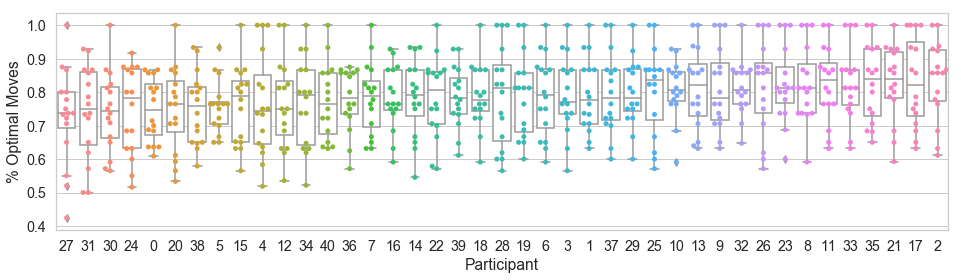

In [253]:
subject_df = pd.DataFrame([
    dict(problem=problem, pid=pid, percent=percent_optimal_moves[problem, pid])
    for problem, pid in np.ndindex(*percent_optimal_moves.shape)
])

f, ax = plt.subplots(figsize=(16, 4))
pid_to_mean = {pid: probs.percent.mean() for pid, probs in subject_df.groupby('pid')}
pid_order = sorted(subject_df.pid.unique(), key=lambda pid: pid_to_mean[pid])

#sns.violinplot(x='pid', y='percent', data=subject_df, ax=ax, order=pid_order)
#sns.swarmplot(x='pid', y='percent', data=subject_df, color='white', ax=ax, order=pid_order)

# or boxplot based
sns.boxplot(x='pid', y='percent', color='white', data=subject_df, ax=ax, order=pid_order)
sns.swarmplot(x='pid', y='percent', data=subject_df, ax=ax, order=pid_order)

ax.set_ylabel('% Optimal Moves')
ax.set_xlabel('Participant')

None

model_p.shape (12,) rand_p.shape (12,)
p_err.shape (50, 1) logp.shape (50, 12) total_logp.shape (50,)
MLE error prob: {'p_err': 0.32653061224489793, 'logp': -10.523567121978845}


/Users/carlos/pu/multigoals/analysis/model.py:23: RuntimeWarning: divide by zero encountered in log
  logp = np.log(noisy_model_p(p_err))


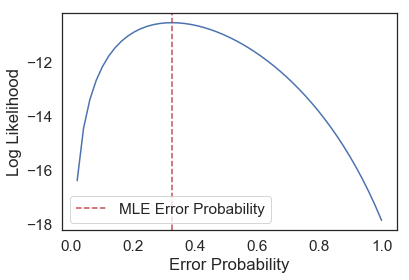

In [16]:
# Fit epsilon-greedy model

agent_idx = 0
problem = blockworld.Blockworld(row.states[0], goals_with_clearing)
model_p = p_actions
rand_p = np.array([1/len(problem.actions(s)) for s in row.states[:-1]])
print('model_p.shape', model_p.shape, 'rand_p.shape', rand_p.shape)
print('MLE error prob:', model.fit_epsilon_greedy_model(model_p, rand_p, debug=True))

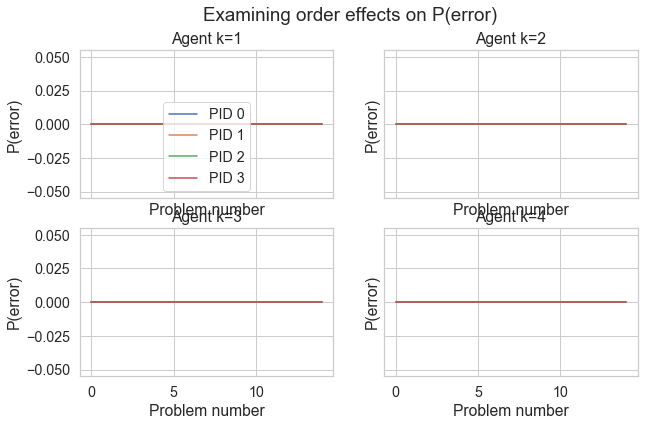

In [194]:
# looking at order effects

f, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

f.suptitle('Examining order effects on P(error)')

for pid in sorted(fiveblock.pid.unique()):
    p_df = fiveblock.loc[fiveblock.pid == pid]
    for agent_idx, ((name, _), ax) in enumerate(zip(agents, axes.flat)):
        p_err_seq = p_err[p_df.problem_idx, pid, agent_idx]
        ax.plot(p_err_seq, label=f'PID {pid}')

for agent_idx, ((name, _), ax) in enumerate(zip(agents, axes.flat)):
    ax.set_title(f'Agent {name}')
    ax.set_ylabel('P(error)')
    ax.set_xlabel('Problem number')

ax = next(axes.flat)
ax.legend()

None

In [49]:
import random

def generate_actions(state, k=None, depth_limit=None, p=None, p_depth=None, p_err=0):
    '''
    Generate actions for agents. We assume that agents replan after each action.

    Can plan with depth limits, k limits (fixed, or with geometric distribution), and take noisy actions as well.
    '''
    problem = blockworld.Blockworld(state, model.make_goals(state))
    if k is None:
        k = len(problem.goals)
    if p is not None:
        k_dist = geom(p)
    if p_depth is not None:
        depth_dist = geom(p_depth)

    actions = []
    states = [state]

    while not problem.goal_test(state):
        if random.uniform(0, 1) < p_err:
            # Take random action
            action = random.choice(problem.actions(state))
            state = problem.result(state, action)
        else:
            if p is not None:
                k = k_dist.rvs()
            if p_depth is not None:
                depth_limit = depth_dist.rvs()
            next_goal, goal_test, h = agent.make_ordered_k_goal_cost_heuristic(problem, state, k=k, debug=False)
            planned_actions, planned_states = agent.A_Star(
                problem,
                h,
                start=state,
                goal_test=goal_test,
                depth_limit=depth_limit,
                shuffle=True)
            action = planned_actions[0]
            state = planned_states[1]
        actions.append(action)
        states.append(state)

    return actions, states

# Fiddling with toy problem. optimal is 5 move solutions.
initial = ((), ('D', 'A'), ('C', 'B'))
print('k=1', [len(generate_actions(initial, k=1)[0]) for _ in range(10)])
print('k=2 (optimal)', [len(generate_actions(initial, k=2)[0]) for _ in range(10)])
print('k=4 (optimal)', [len(generate_actions(initial, k=4)[0]) for _ in range(10)])
print('k=2 p_err', [len(generate_actions(initial, k=2, p_err=0.2)[0]) for _ in range(10)])
print('geom p=0.8', [len(generate_actions(initial, p=0.8)[0]) for _ in range(10)])
print('geom depth p=0.08', [len(generate_actions(initial, p_depth=0.08)[0]) for _ in range(10)])

k=1 [6, 5, 5, 6, 5, 6, 5, 5, 6, 6]
k=2 (optimal) [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
k=4 (optimal) [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
k=2 p_err [6, 13, 5, 5, 7, 7, 5, 7, 10, 9]
geom p=0.8 [6, 5, 5, 5, 6, 6, 5, 5, 5, 6]
geom depth p=0.08 [5, 5, 5, 5, 7, 6, 5, 5, 5, 5]


In [47]:
import json
with open('../../cocosci-blockworld/static/json/trials.json', 'r') as f:
    trials_json = json.load(f)

In [75]:
# parameter recovery: generate a dataset.

import random
random.seed(1338)

generated_df = dict(pid=[], states=[], actions=[])

letters = [chr(ord('a')+i) for i in range(5)]
# Set letter to empty string to jointly optimize
#letters = ['' for i in range(5)]


problems_to_test = problems_to_analyze
#problems_to_test = [tuple(tuple(col) for col in t['initial']) for t in trials_json['B=6']]

generating_agents = [
    (f'k=1{l}', dict(k=1)) for l in letters
] + [
    (f'k=2{l}', dict(k=2)) for l in letters
] + [
    (f'k=3{l}', dict(k=3)) for l in letters
] + [
    (f'k=4{l}', dict(k=4)) for l in letters
] + [
    (f'k=2{l} p_err', dict(k=2, p_err=0.2)) for l in letters
] + [
    (f'p=0.6 {l}', dict(p=0.6)) for l in letters
] + [
    (f'p=0.3 {l}', dict(p=0.3)) for l in letters
]

generating_agents = [
    (f'k=2{l}', dict(k=2)) for l in letters
] + [
    (f'p=0.5 {l}', dict(p=0.5)) for l in letters
] + [
    (f'p_depth=0.1 {l}', dict(p_depth=0.1)) for l in letters
]

for agent_name, agent_kwargs in generating_agents:
    for initial in problems_to_test:
        actions, states = generate_actions(initial, **agent_kwargs)
        assert len(actions) == len(states) - 1
        generated_df['states'].append(states)
        generated_df['actions'].append(actions)
        generated_df['pid'].append(agent_name)

generated_df = pd.DataFrame(generated_df)
generated_df.shape

(225, 3)

## Finding P(a)

In [410]:
# parameter recovery: find p(action) for agents to this dataset

max_depth = max(
    model.optimal_num_actions(s)
    for _, row in tqdm(list(df_to_analyze.iterrows()))
    for s in row.states[:-1]
)

print(f'Max depth {max_depth}')

kvals = [1, 2, 3, 4, 5, 6]
dvals = range(1, max_depth + 1)

agents = [
    (f'k={k}', dict(k=k))
    for k in kvals
] + [
    (f'd={d}', dict(depth_limit=d))
    for d in dvals
] + [
    (f'k={k},d={d}', dict(k=k, depth_limit=d))
    for k in kvals
    for d in dvals
]

def _make_model_inputs(df):
    curr_df = df.copy()
    curr_df['initial_state'] = curr_df['states'].apply(lambda s: s[0])

    # Some code for error likelihood. Assumes all states have same goals/# blocks
    arbitrary_state = curr_df['initial_state'].values[0]
    arbitrary_problem = blockworld.Blockworld(arbitrary_state, model.make_goals(arbitrary_state))
    def _err_likelihood(state, action):
        # HACK should we first check to see if action is even in there??
        return 1/len(arbitrary_problem.actions(state))

    # Indexed by (pid, initial state). Contains dict with
    # - model_p: (size # agents X # actions) and
    # - rand_p: (size # actions)
    subject_p = {
        (row.pid, row.initial_state): dict(
            model_p=np.zeros((len(agents), len(row.actions))),
            rand_p=np.zeros((len(row.actions),)),
        )
        for _, row in curr_df.iterrows()
    }

    agent_kwargs = [kwargs for _, kwargs in agents] # used to find other agents below

    # Modeling. We ensure innermost loop is over the same problem to best exploit LRU cache.
    # innermost loop with different problems or different agents would make it hard to cache
    # shared moves between participants.
    # This is ultimately why we structure data flow in this function in such a particular way.
    # HACK HACK however not clear that perf is really that impacted....
    # HACK although it might be by 6 block problems????
    for agent_idx, (agent_name, get_actions_kwargs) in enumerate(tqdm(agents)):
        get_actions_fn = lambda s: model.get_actions(s, **get_actions_kwargs)
        for _, rows in curr_df.groupby('initial_state'):
            for _, row in rows.iterrows():
                # Find or create our appropriate state
                subject_action_p = subject_p[row.pid, row.initial_state]
                for action_idx, (state, participant_action) in enumerate(zip(row.states[:-1], row.actions)):
                    # HACK HACK
                    # So find out the optimal length. We should never look beyond that depth.
                    optimal_length = model.optimal_num_actions(state)
                    # If we're past optimal length, then we should just use that instead of recomputing.
                    if 'depth_limit' in get_actions_kwargs and get_actions_kwargs['depth_limit'] > optimal_length:
                        # HACK check to see if this does the right thing with k?
                        optimal_idx = agent_kwargs.index(dict(get_actions_kwargs, depth_limit=optimal_length))
                        subject_action_p['model_p'][agent_idx, action_idx] = subject_action_p['model_p'][optimal_idx, action_idx]
                    else:
                        subject_action_p['model_p'][agent_idx, action_idx] = model.probability_of_action(
                            state, participant_action, get_actions_fn,
                            uniform_action_selection=True)
                    subject_action_p['rand_p'][action_idx] = _err_likelihood(state, participant_action)

    # Now we make big matrices of model_p and rand_p for each subject
    model_inputs = {}
    for pid in curr_df['pid'].unique():
        m = []
        r = []
        # assumes every pid did every problem
        for initial_state in curr_df['initial_state'].unique():
            m.append(subject_p[pid, initial_state]['model_p'])
            r.append(subject_p[pid, initial_state]['rand_p'])
        model_inputs[pid] = dict(
            model_p=np.concatenate(m, axis=-1),
            rand_p=np.concatenate(r),
        )
    return model_inputs

curr_df = df_to_analyze
# taking 2 problems for 2 people across 2 tries to simplify computation
#curr_df = curr_df.loc[curr_df.initial_state.isin(curr_df.initial_state.values[:2])].head(8)

agent_names = [name for name, _ in agents]
model_inputs = _make_model_inputs(curr_df)

Max depth 15


In [411]:
import joblib
joblib.dump(dict(
    model_inputs=model_inputs,
    agent_names=agent_names,
), f'action_probs-v{version}.z')

['action_probs-v1.4.z']

In [784]:
# HACK can use this to load previous action probs
#'''
ap = joblib.load('action_probs-v1.2.z')
model_inputs = ap['model_inputs']
agent_names = ap['agent_names']

print('number pids', len(model_inputs.keys()))
print('size of model_p', model_inputs[list(model_inputs.keys())[0]]['model_p'].shape)
print('number of agents', len(agent_names))
#'''

number pids 18
size of model_p (90, 194)
number of agents 90


In [138]:
# Now fitting model

from scipy.optimize import minimize
from scipy.stats.distributions import geom, binom
import re

def _fit_models(problem, agent_names, action_lk, rand_p, random_x0=False):
    # Values of k to test. Right now we simplify by assuming all problems have same # of goals
    max_k = len(problem.goals)
    # HACK HACK
    kmatches = [re.match(r'^k=(\d+)$', agent_name) for agent_name in agent_names]
    max_k = max([int(m.group(1)) for m in kmatches if m])
    ks = np.arange(1, max_k+1)

    # Find indexes of k-agents in action_lk
    k_agent_idxs = [agent_names.index(f'k={k}') for k in ks]
    k_action_lk = action_lk[k_agent_idxs, :]

    # Values of d to test. We pick max value from agents
    dmatches = [re.match(r'^d=(\d+)$', agent_name) for agent_name in agent_names]
    max_d = max([int(m.group(1)) for m in dmatches if m])
    ds = np.arange(1, max_d+1)

    # Find indexes of d-agents in action_lk
    d_agent_idxs = [agent_names.index(f'd={d}') for d in ds]
    d_action_lk = action_lk[d_agent_idxs, :]

    # Find indexes of each pair of kd-agents in action_lk
    kd_agent_idxs = [
        [
            agent_names.index(f'k={k},d={d}')
            for d in ds
        ]
        for k in ks
    ]
    kd_action_lk = action_lk[kd_agent_idxs, :]
    assert kd_action_lk.shape == (len(ks), len(ds), len(rand_p))

    # Make sure shapes are good
    assert len(rand_p.shape) == 1
    assert action_lk.shape == (len(agent_names), len(rand_p))

    def _neg_ll(params):
        p, p_err = params
        # HACK for some reason this fn can get called by minimize() with an out of bounds value.
        p = max(min(p, 1), 0)
        p_err = max(min(p_err, 1), 0)

        # Set up geometric distribution over k
        pk = geom(p).pmf(ks)
        pk[-1] = 1 - pk[:-1].sum()  # tail probability of all k >= max_k

        # Determine model_p given this distribution over k
        model_p = pk.dot(k_action_lk)
        assert model_p.shape == rand_p.shape

        # Determine prob given prob of noise
        noisy_p = (1 - p_err) * model_p + p_err * rand_p

        return -np.log(noisy_p).sum()

    def _neg_ll_depth(params):
        # HACK HACK HACK copied from above...........
        p, p_err = params
        # HACK for some reason this fn can get called by minimize() with an out of bounds value.
        p = max(min(p, 1), 0)
        p_err = max(min(p_err, 1), 0)

        # Set up geometric distribution over d
        pd = geom(p).pmf(ds)
        pd[-1] = 1 - pd[:-1].sum()  # tail probability of all d >= max_d

        # Determine model_p given this distribution over d
        model_p = pd.dot(d_action_lk)
        assert model_p.shape == rand_p.shape

        # Determine prob given prob of noise
        noisy_p = (1 - p_err) * model_p + p_err * rand_p

        return -np.log(noisy_p).sum()

    def _neg_ll_k_and_depth(params):
        # HACK HACK HACK copied from above...........
        p_k, p_depth, p_err = params
        p_k = max(min(p_k, 1), 0)
        p_depth = max(min(p_depth, 1), 0)
        p_err = max(min(p_err, 1), 0)

        # Set up geometric distribution over k
        pk = geom(p_k).pmf(ks)
        pk[-1] = 1 - pk[:-1].sum()  # tail probability of all k >= max_k

        # Set up geometric distribution over d
        pd = geom(p_depth).pmf(ds)
        pd[-1] = 1 - pd[:-1].sum()  # tail probability of all d >= max_d

        # Set up distribution of k/d pairs
        joint_kd = pk[:, np.newaxis] * pd

        # Determine model_p given this distribution over k/d
        probs = joint_kd[:, :, np.newaxis] * kd_action_lk
        assert probs.shape == (len(ks), len(ds), len(rand_p))
        model_p = np.sum(probs, axis=(0, 1))
        assert model_p.shape == rand_p.shape

        # Determine prob given prob of noise
        noisy_p = (1 - p_err) * model_p + p_err * rand_p

        return -np.log(noisy_p).sum()

    def _neg_ll_noise(params, model_p):
        p_err, = params
        p_err = max(min(p_err, 1), 0)

        # Determine prob given prob of noise
        noisy_p = (1 - p_err) * model_p + p_err * rand_p

        #print('_neg_ll_noise', p_err, -np.log(noisy_p).sum())
        return -np.log(noisy_p).sum()

    out = {}

    # Trying to avoid issues when model_p can be 0
    safe_bounds = [1e-08, 1-1e-08]
    if random_x0:
        start_val = lambda: random.uniform(*safe_bounds)
    else:
        start_val = lambda: 0.5

    #for kidx, k in enumerate(ks):
    for agent_idx, agent_name in enumerate(agent_names):
        # Find model_p for this k
        model_p = action_lk[agent_idx, :]
        res = minimize(
            _neg_ll_noise, np.array([start_val()]), bounds=[safe_bounds],
            args=(model_p,), method='L-BFGS-B',
        )
        assert res.success, f'Model fitting failed. {res}'
        out[agent_name] = dict(p_err=res.x[0], logp=-res.fun)#, optres=res)

    res = minimize(_neg_ll, np.array([start_val(), start_val()]), bounds=[safe_bounds, safe_bounds], method='L-BFGS-B')
    assert res.success, f'Model fitting failed. {res}'
    p, p_err = res.x
    out['geom_k'] = dict(p=p, p_err=p_err, logp=-res.fun)#, optres=res)

    res = minimize(_neg_ll_depth, np.array([start_val(), start_val()]), bounds=[safe_bounds, safe_bounds], method='L-BFGS-B')
    assert res.success, f'Model fitting failed. {res}'
    p, p_err = res.x
    out['geom_d'] = dict(p=p, p_err=p_err, logp=-res.fun)#, optres=res)

    res = minimize(
        _neg_ll_k_and_depth,
        np.array([start_val(), start_val(), start_val()]),
        bounds=[safe_bounds, safe_bounds, safe_bounds],
        method='L-BFGS-B')
    assert res.success, f'Model fitting failed. {res}'
    p_k, p_depth, p_err = res.x
    out['geom_kd'] = dict(p_k=p_k, p_depth=p_depth, p_err=p_err, logp=-res.fun)#, optres=res)

    return out


In [139]:
arbitrary_state = problems_to_analyze[0]
arbitrary_problem = blockworld.Blockworld(arbitrary_state, model.make_goals(arbitrary_state))

pid_to_fit = {
    pid: _fit_models(arbitrary_problem, agent_names, model_inputs[pid]['model_p'], model_inputs[pid]['rand_p'])
    for pid in model_inputs.keys()
}

In [ ]:
def _truncated_discrete_dist(dist, vals):
    '''
    Uses a discrete distribution to determine probabilities of the supplied ascending sequence which starts at 1.
    Probability for max value includes values larger than max value.
    '''
    # Set up discrete distribution over the values.
    # We assume the values are an increasing sequence, starting at 1.
    p = dist.pmf(vals)
    p[-1] = 1 - p[:-1].sum()  # We give largest value the tail probability of all values >= max value
    # HACK HACK what to do about value 0
    return p


def _noise_model_loglik(p_err, model_p, rand_p):
    # This is sometimes called with an out of bounds value
    p_err = max(min(p_err, 1), 0)

    # Determine prob given prob of noise
    noisy_p = (1 - p_err) * model_p + p_err * rand_p

    return np.log(noisy_p).sum()


def _latent_variable_model(params, action_lk, values, rand_p, _make_dist):
    p, p_err = params
    # HACK for some reason this fn can get called by minimize() with an out of bounds value.
    p = max(min(p, 1), 0)

    # Set up distribution over values
    p_of_value = _truncated_discrete_dist(_make_dist(p), values)

    # Determine model_p given this distribution over k
    model_p = p_of_value.dot(action_lk)
    assert model_p.shape == rand_p.shape

    return -_noise_model_loglik(p_err, model_p, rand_p)


def _simple_minimize(fn, num_params, args=(), random_x0=False, bounds=None):
    eps = 1e-08
    # Trying to avoid issues when a probability can be 0
    safe_bounds = [eps, 1-eps]
    if bounds is None:
        bounds = [safe_bounds] * num_params

    if random_x0:
        start_val = lambda bound: random.uniform(*bound)
    else:
        start_val = lambda bound: 0.5

    x0 = [start_val(bound) for bound in bounds]
    res = minimize(fn, x0, bounds=bounds, args=args, method='L-BFGS-B')
    assert res.success, f'Model fitting failed. {res}'
    #assert np.all(x0 != res.x), 'Model fit was the same as input parameters.'
    if np.any(x0 == res.x):
        return None
    return res


def _minimize_discrete_param(values, fit_model, repetitions=5):
    models = [
        (fit_model(value), value)
        for value in values
        for _ in range(repetitions)
    ]
    models = [(m, v) for (m, v) in models if m is not None]
    model, value = min(models, key=lambda model_and_value: model_and_value[0].fun)
    return model, value


def _hi(agent_names, action_lk, rand_p):
    kmatches = [re.match(r'^k=(\d+)$', agent_name) for agent_name in agent_names]
    max_k = max([int(m.group(1)) for m in kmatches if m])
    ks = np.arange(1, max_k+1)

    # Find indexes of k-agents in action_lk
    k_agent_idxs = [agent_names.index(f'k={k}') for k in ks]
    k_action_lk = action_lk[k_agent_idxs, :]

    # Values of d to test. We pick max value from agents
    dmatches = [re.match(r'^d=(\d+)$', agent_name) for agent_name in agent_names]
    max_d = max([int(m.group(1)) for m in dmatches if m])
    ds = np.arange(1, max_d+1)

    # Find indexes of d-agents in action_lk
    d_agent_idxs = [agent_names.index(f'd={d}') for d in ds]
    d_action_lk = action_lk[d_agent_idxs, :]

    for dist_name, dist_fn in [
        ('binom', lambda p: binom(n_k, p)),
        ('geom', lambda p: geom(p)),
    ]:
        logpss = []
        all_results = []
        for n_k in range(1, 50):
            r = [
                (_simple_minimize(_latent_variable_model, 2, args=(d_action_lk, ds, rand_p, dist_fn)), n_k)
                for _ in range(10)
            ]
            r = [(m, v) for (m, v) in r if m is not None]
            if not r:
                continue
            all_results += r
            # Find best fit
            res, _ = min(r, key=lambda res_and_n: res_and_n[0].fun)
            p_k, p_err = res.x
            logpss.append((n_k, -res.fun))
            #print('hi', n_k, f'logp={-res.fun} p_k={p_k} p_err={p_err}')
        res, n_k = min(all_results, key=lambda res_and_n: res_and_n[0].fun)
        p_k, p_err = res.x
        print(f'best result for {dist_name}: logp={-res.fun} p_k {p_k}, p_err {p_err}, n_k {n_k}')

        plt.plot(*zip(*logpss), '-o', label=dist_name)
    plt.legend()

    # using the nice new function...
    res, n_k = _minimize_discrete_param(
        range(1, 50),
        lambda n_k: _simple_minimize(_latent_variable_model, 2, args=(k_action_lk, ks, rand_p, lambda p: binom(n_k, p))))
    p_k, p_err = res.x
    print(f'best result for binom using new method: logp={-res.fun} p_k {p_k}, p_err {p_err}, n_k {n_k}')

pid = 10 # weird shape!
#for pid in tqdm(list(model_inputs.keys())[:10]):
plt.figure()
_hi(agent_names, model_inputs[pid]['model_p'], model_inputs[pid]['rand_p'])


In [143]:
from scipy.stats.distributions import binom


def _find_k_and_d_agents(agent_names):
    # find k vals
    kmatches = [re.match(r'^k=(\d+)$', agent_name) for agent_name in agent_names]
    max_k = max([int(m.group(1)) for m in kmatches if m])
    ks = np.arange(1, max_k+1)
    k_agent_idxs = [agent_names.index(f'k={k}') for k in ks]

    # find d vals
    dmatches = [re.match(r'^d=(\d+)$', agent_name) for agent_name in agent_names]
    max_d = max([int(m.group(1)) for m in dmatches if m])
    ds = np.arange(1, max_d+1)
    d_agent_idxs = [agent_names.index(f'd={d}') for d in ds]

    # Find indexes of each pair of kd-agents in action_lk
    kd_agent_idxs = [
        [
            agent_names.index(f'k={k},d={d}')
            for d in ds
        ]
        for k in ks
    ]

    return ks, k_agent_idxs, ds, d_agent_idxs, kd_agent_idxs


def _add_binomial_models(pid_to_fit, agent_names):
    ks, k_agent_idxs, ds, d_agent_idxs, kd_agent_idxs = _find_k_and_d_agents(agent_names)

    for pid, fits in tqdm(pid_to_fit.items()):
        action_lk = model_inputs[pid]['model_p']
        rand_p = model_inputs[pid]['rand_p']

        for model_name, value_action_lk, values in [
            ('binom_k', action_lk[k_agent_idxs, :], ks),
            ('binom_d', action_lk[d_agent_idxs, :], ds),
        ]:
            # HACK just doing up to large # since some things actually like to go that far out...
            res, n = _minimize_discrete_param(range(1, 30), lambda n: _simple_minimize(
                _latent_variable_model,
                2,
                args=(value_action_lk, values, rand_p, lambda p: binom(n, p))))
            # HACK will res be None sometimes???
            p, p_err = res.x
            fits[model_name] = dict(p=p, p_err=p_err, n=n, logp=-res.fun)

_add_binomial_models(pid_to_fit, agent_names)

KeyboardInterrupt: 

In [144]:
# Add fixed models

def _add_fixed_models(pid_to_fit, agent_names):
    ks, k_agent_idxs, ds, d_agent_idxs, kd_agent_idxs = _find_k_and_d_agents(agent_names)

    for pid, fits in pid_to_fit.items():
        for model_name, pattern in [
            ('fixed_k', r'^k=(?P<k>\d+)$'),
            ('fixed_d', r'^d=(?P<d>\d+)$'),
            ('fixed_kd', r'^k=(?P<k>\d+),d=(?P<d>\d+)$'),
        ]:
            agent_name, max_fit = max([
                (agent_name, fits[agent_name]) for agent_name in agent_names
                if re.match(pattern, agent_name)
            ], key=lambda name_fit: name_fit[1]['logp'])
            m = re.match(pattern, agent_name)
            # HACK adding in k/d info
            fits[model_name] = dict(max_fit, **{k: int(v) for k, v in m.groupdict().items()})

_add_fixed_models(pid_to_fit, agent_names)

In [423]:
from scipy.stats.distributions import poisson

def _truncated_poisson_pmf(rate, values):
    # Make a poisson distribution over value, which is a range from 1 to a final value.
    dist = poisson(rate)
    p_of_value = _truncated_discrete_dist(dist, values)
    # We make a truncated poisson by removing 0's mass (which got caught in the tail) and then renormalizing
    p_of_value[-1] -= dist.pmf(0)
    p_of_value /= p_of_value.sum()
    return p_of_value

def _latent_variable_poisson_model(params, action_lk, values, rand_p):
    rate, p_err = params

    # Set up distribution over values
    p_of_value = _truncated_poisson_pmf(rate, values)

    # Determine model_p given this distribution over k
    model_p = p_of_value.dot(action_lk)
    assert model_p.shape == rand_p.shape

    return -_noise_model_loglik(p_err, model_p, rand_p)

def _latent_variables_poisson_model(params, action_lk, var1, var2, rand_p):
    rate1, rate2, p_err = params

    # Set up distribution over values
    p_var1 = _truncated_poisson_pmf(rate1, var1)
    p_var2 = _truncated_poisson_pmf(rate2, var2)

    # Make joint distribution
    p_joint = p_var1[:, np.newaxis] * p_var2

    # Determine model_p given this distribution over params
    probs = p_joint[:, :, np.newaxis] * action_lk
    assert probs.shape == (len(var1), len(var2), len(rand_p))
    model_p = np.sum(probs, axis=(0, 1))
    assert model_p.shape == rand_p.shape

    return -_noise_model_loglik(p_err, model_p, rand_p)

def _add_poisson_models(pid_to_fit, agent_names, model_inputs):
    eps = 1e-08
    # Trying to avoid issues when a probability can be 0
    safe_bounds = [eps, 1-eps]

    ks, k_agent_idxs, ds, d_agent_idxs, kd_agent_idxs = _find_k_and_d_agents(agent_names)

    for pid, fits in pid_to_fit.items():
        action_lk = model_inputs[pid]['model_p']
        rand_p = model_inputs[pid]['rand_p']

        # Now add poisson models
        for model_name, value_action_lk, values in [
            ('poisson_k', action_lk[k_agent_idxs, :], ks),
            ('poisson_d', action_lk[d_agent_idxs, :], ds),
        ]:
            res = _simple_minimize(
                _latent_variable_poisson_model,
                2,
                # HACK is 100 an ok upper bound??? or too high...
                bounds=[[eps, 100], safe_bounds],
                args=(value_action_lk, values, rand_p))
            # HACK will res be None sometimes???
            rate, p_err = res.x
            fits[model_name] = dict(rate=rate, p_err=p_err, logp=-res.fun)

        # And add joint model over k/d
        kd_action_lk = action_lk[kd_agent_idxs, :]
        assert kd_action_lk.shape == (len(ks), len(ds), len(rand_p))
        res = _simple_minimize(
            _latent_variables_poisson_model,
            3,
            # HACK is 100 an ok upper bound??? or too high...
            bounds=[[eps, 100], [eps, 100], safe_bounds],
            args=(kd_action_lk, ks, ds, rand_p))
        # HACK will res be None sometimes???
        rate_k, rate_d, p_err = res.x
        fits['poisson_kd'] = dict(rate_k=rate_k, rate_d=rate_d, p_err=p_err, logp=-res.fun)

_add_poisson_models(pid_to_fit, agent_names, model_inputs)

TypeError: _add_poisson_models() missing 1 required positional argument: 'model_inputs'

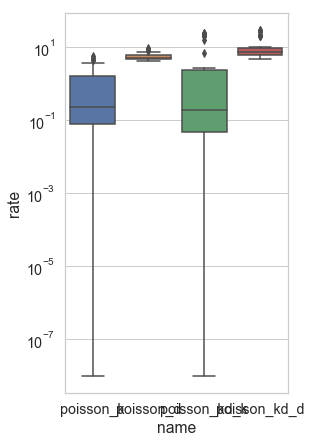

In [146]:
fitted_param_df = []
for pid, fits in sorted(pid_to_fit.items()):
    fitted_param_df += [
        dict(name=name, rate=fits[name]['rate'])
        for name in ['poisson_k', 'poisson_d']
    ] + [
        dict(name='poisson_kd_k', rate=fits['poisson_kd']['rate_k']),
        dict(name='poisson_kd_d', rate=fits['poisson_kd']['rate_d']),
    ]

fitted_param_df = pd.DataFrame(fitted_param_df)
f, ax = plt.subplots(figsize=(4, 7))
sns.boxplot(x='name', y='rate', data=fitted_param_df, ax=ax)
#ax.set_yticks(np.arange(0, 9, 0.5))
ax.set_yscale('log')
None

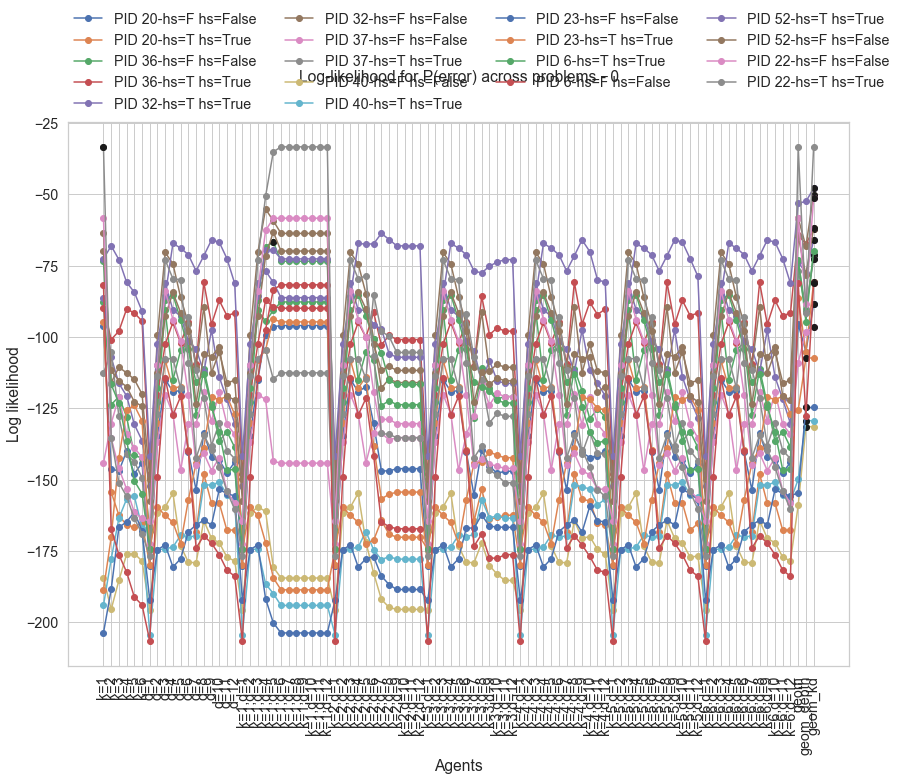

In [694]:
# parameter recovery

sns.set_style("whitegrid")

agent_names_for_plot = agent_names + ['geom_k', 'geom_d', 'geom_kd']

all_pids = list(curr_df.pid.unique())
for pids in [
    all_pids,

    # chunking subjects into 5s
    #all_pids[idx:idx+5]
    #for idx in range(0, len(all_pids), 5)

    # works with newer code
    #[name for name, _ in generating_agents[idx:idx+len(letters)]]
    #for idx in range(0, len(generating_agents), len(letters))
]:
    f, ax = plt.subplots(figsize=(14, 10))

    #names = [name for name, _ in agents]
    for pid in pids:
        fits = pid_to_fit[pid]
        some_rows = df_to_analyze.loc[df_to_analyze.pid==pid]
        high_stakes = some_rows.high_stakes.values[0]
        raw_pid = some_rows.raw_pid.values[0]
        ll = np.array([fits[name]['logp'] for name in agent_names_for_plot])
        #ll = [subject_p_err[pid, name]['logp'] for name in names]
        ax.plot(agent_names_for_plot, ll, '-o', label=f'PID {raw_pid} hs={high_stakes}')
        max_agent = np.argmax(ll)
        max_dot = ax.plot(agent_names_for_plot[max_agent], ll[max_agent], 'o', c='k')

    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=4, 
                borderaxespad=0, frameon=False)

    ax.set_title(f'Log-likelihood for P(error) across problems - {list(pids)[0]}\n\n')
    ax.set_xlabel('Agents')
    ax.set_ylabel('Log likelihood')
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

In [424]:
# HACK getting exp1 model fits for use in next cell...

def _fit_exp(fname):
    print(f'Fitting for {fname}')
    ap = joblib.load(fname)
    model_inputs = ap['model_inputs']
    agent_names = ap['agent_names']

    print('number pids', len(model_inputs.keys()))
    print('size of model_p', model_inputs[list(model_inputs.keys())[0]]['model_p'].shape)
    print('number of agents', len(agent_names))

    # Now fit things...
    arbitrary_state = problems_to_analyze[0]
    arbitrary_problem = blockworld.Blockworld(arbitrary_state, model.make_goals(arbitrary_state))

    pid_to_fit = {
        pid: _fit_models(arbitrary_problem, agent_names, model_inputs[pid]['model_p'], model_inputs[pid]['rand_p'])
        for pid in model_inputs.keys()
    }
    _add_fixed_models(pid_to_fit, agent_names)
    _add_poisson_models(pid_to_fit, agent_names, model_inputs)

    return pid_to_fit

exp1_pid_to_fit = _fit_exp('action_probs-v1.1.z')
exp3_pid_to_fit = _fit_exp('action_probs-v1.3.z')

Fitting for action_probs-v1.1.z
number pids 41
size of model_p (111, 272)
number of agents 111
Fitting for action_probs-v1.3.z
number pids 78
size of model_p (118, 267)
number of agents 118


In [412]:
exp4_pid_to_fit = _fit_exp('action_probs-v1.4.z')

Fitting for action_probs-v1.4.z
number pids 94
size of model_p (111, 261)
number of agents 111


In [ ]:
# Experiment 2a: How does geom p change without a bonus?

curr_df = df_to_analyze.copy()

pid_to_info = {
    row.pid: (int(row.raw_pid.split('-')[0]), row.no_bonus)
    for _, row in curr_df.iterrows()
}

def _expected_k(p):
    p = _truncated_discrete_dist(geom(p), kvals)
    return (p * kvals).sum()

def _make_df_row(fits):
    return dict(
        geom_k_p=fits['geom_k']['p'],
        geom_d_p=fits['geom_d']['p'],
        one_minus_geom_k_p=1-fits['geom_k']['p'],
        geom_exp_k=_expected_k(fits['geom_k']['p']),
        geom_k_p_err=fits['geom_k']['p_err'],
        geom_k_logp=fits['geom_k']['logp'],
        geom_d_logp=fits['geom_d']['logp'],
        fixed_k_param=fits['fixed_k']['k'],
        fixed_k_logp=fits['fixed_k']['logp'],
    )

exp4_df = pd.DataFrame([
    dict(
        pid=pid_to_info[pid][0], # This is true pid
        condition='No Bonus' if pid_to_info[pid][1] else 'Bonus',
#        labelx=('geomk' if fits['geom_k']['logp'] > fits['geom_d']['logp'] else 'geomd') + ('3x' if pid_to_info[pid][1] else '1x'),
        **_make_df_row(fits),
    )
    for pid, fits in exp4_pid_to_fit.items()
])

exp2_df = pd.concat([
    pd.DataFrame([
        dict(
            pid=f'exp1-{pid}',
            condition='none',
#            labelx=('geomk' if fits['geom_k']['logp'] > fits['geom_d']['logp'] else 'geomd') + 'exp1',
            **_make_df_row(fits),
        )
        for pid, fits in exp1_pid_to_fit.items()
    ]),
    exp4_df,
])

for param in ['geom_k_p', 'geom_exp_k']:
    ga = exp4_df[param].mean()
    exp4_df[param+'_nosubjvar'] = exp4_df.groupby('pid')[param].transform(lambda x: (x - x.mean())) + ga

#exp2_df = exp4_df

exp2_df.to_csv('geom_k_models.csv', index=False)

'''
# https://stackoverflow.com/questions/26046208/normalize-dataframe-by-group
def hi(xx):
    print(xx)
    print(xx.loc[xx.high_stakes])
exp2_df.groupby('pid').transform(hi)#lambda x: (x - x.mean()) / x.std())
'''

for param in ['geom_exp_k', 'geom_k_p', 'geom_k_p_err', 'geom_k_logp', 'fixed_k_param', 'fixed_k_logp']:
    f, ax = plt.subplots()
    order = ['none', 'No Bonus', 'Bonus']

    alpha = 0.2
    sns.pointplot(
        x='condition', y=param,
        hue='pid',
        data=exp2_df, dodge=0.2,
        ax=ax,
        order=order,
    )
    # Mega hack
    # https://github.com/mwaskom/seaborn/issues/979
    new_color = tuple(sns.color_palette()[0]) + (alpha,)
    for patch in ax.get_children():
        for n in ['facecolor', 'edgecolor', 'linecolor', 'color']:
            if not hasattr(patch, f'get_{n}'):
                continue
            c = getattr(patch, f'get_{n}')()
            if isinstance(c, str):
                continue
            if not isinstance(c, tuple) and len(c.shape) > 1:
                c = c[0, :]
            if len(c) == 4:
                r, g, b, _ = c
            else:
                r, g, b = c
            if (r, g, b) == (1, 1, 1):
                continue
            getattr(patch, f'set_{n}')(new_color)

    # Also add summary
    sns.pointplot(
        x='condition', y=param,
        #hue='pid',
        data=exp2_df,
        ax=ax,
        order=order,
    )

    ax.legend().remove()


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


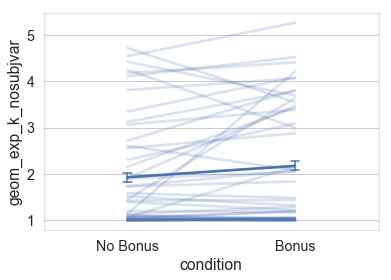

In [414]:

f, ax = plt.subplots()
order = ['No Bonus', 'Bonus']

param = 'geom_exp_k'

alpha = 0.2
sns.pointplot(
    x='condition', y=param,
    hue='pid',
    data=exp2_df,# dodge=0.2,
    ax=ax,
    order=order,
    markers='',
)
# Mega hack
# https://github.com/mwaskom/seaborn/issues/979
new_color = tuple(sns.color_palette()[0]) + (alpha,)
for patch in ax.get_children():
    for n in ['facecolor', 'edgecolor', 'linecolor', 'color']:
        if not hasattr(patch, f'get_{n}'):
            continue
        c = getattr(patch, f'get_{n}')()
        if isinstance(c, str):
            continue
        if not isinstance(c, tuple) and len(c.shape) > 1:
            c = c[0, :]
        if len(c) == 4:
            r, g, b, _ = c
        else:
            r, g, b = c
        if (r, g, b) == (1, 1, 1):
            continue
        getattr(patch, f'set_{n}')(new_color)

# Also add summary
sns.pointplot(
    x='condition', y=param+'_nosubjvar',
    #hue='pid',
    data=exp2_df,
    ax=ax,
    order=order,
    markers='',
    capsize=.05,
    errwidth=1.5,
)

ax.legend().remove()


(array([ 2.,  0.,  0.,  1.,  1.,  0.,  0.,  3., 18.,  6.,  5.,  1.,  0.,
         3.,  1.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-1.24383535, -1.10028734, -0.95673932, -0.8131913 , -0.66964328,
        -0.52609526, -0.38254724, -0.23899923, -0.09545121,  0.04809681,
         0.19164483,  0.33519285,  0.47874087,  0.62228889,  0.7658369 ,
         0.90938492,  1.05293294,  1.19648096,  1.34002898,  1.483577  ,
         1.62712502,  1.77067303,  1.91422105,  2.05776907,  2.20131709,
         2.34486511,  2.48841313,  2.63196114,  2.77550916,  2.91905718,
         3.0626052 ]),
 <a list of 30 Patch objects>)

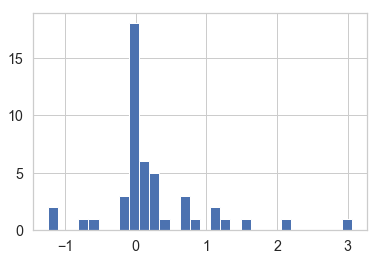

In [415]:

f, ax = plt.subplots()
order = ['No Bonus', 'Bonus']

param = 'geom_exp_k'

grp = exp2_df.pivot('pid', 'condition', param)

#sns.distplot(grp['Bonus'] - grp['No Bonus'])
plt.hist(grp['Bonus'] - grp['No Bonus'], bins=30)

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


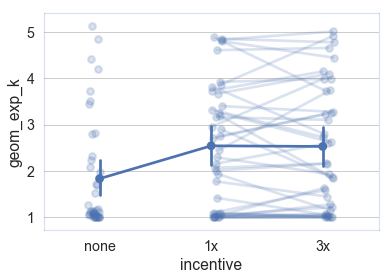

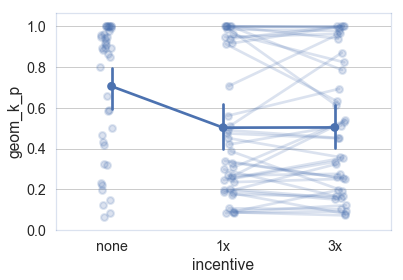

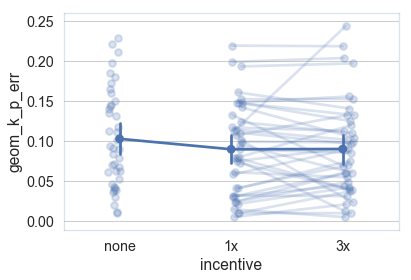

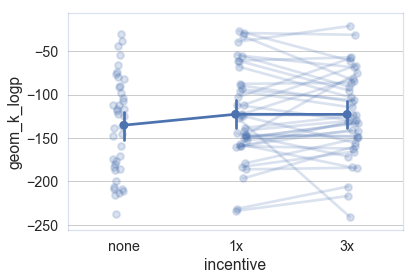

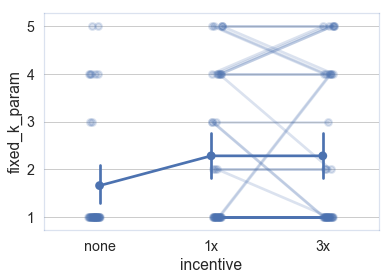

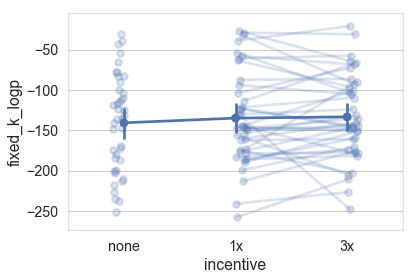

In [312]:
# Experiment 2: How does geom p change in/out of high stakes?

curr_df = df_to_analyze

pid_to_info = {
    row.pid: (int(row.raw_pid.split('-')[0]), row.high_stakes)
    for _, row in curr_df.iterrows()
}

def _expected_k(p):
    p = _truncated_discrete_dist(geom(p), kvals)
    return (p * kvals).sum()

def _make_df_row(fits):
    return dict(
        geom_k_p=fits['geom_k']['p'],
        geom_d_p=fits['geom_d']['p'],
        one_minus_geom_k_p=1-fits['geom_k']['p'],
        geom_exp_k=_expected_k(fits['geom_k']['p']),
        geom_k_p_err=fits['geom_k']['p_err'],
        geom_k_logp=fits['geom_k']['logp'],
        geom_d_logp=fits['geom_d']['logp'],
        fixed_k_param=fits['fixed_k']['k'],
        fixed_k_logp=fits['fixed_k']['logp'],
    )

exp3_df = pd.DataFrame([
    dict(
        pid=pid_to_info[pid][0], # This is true pid
        incentive='3x' if pid_to_info[pid][1] else '1x',
        labelx=('geomk' if fits['geom_k']['logp'] > fits['geom_d']['logp'] else 'geomd') + ('3x' if pid_to_info[pid][1] else '1x'),
        **_make_df_row(fits),
    )
    for pid, fits in exp3_pid_to_fit.items()
])
for _, row in exp3_df.iterrows():
    if row.incentive=='3x':
        continue
    pid_to_model_category[row.pid] = 'geom_k' if row.geom_k_logp > row.geom_d_logp else 'geom_d'
exp3_df['labelx'] = exp3_df.apply(
    lambda row: pid_to_model_category[row.pid]+'_'+('3x' if pid_to_info[row.pid][1] else '1x'),
    axis=1)

exp2_df = pd.concat([
    pd.DataFrame([
        dict(
            pid=f'exp1-{pid}',
            incentive='none',
            labelx=('geomk' if fits['geom_k']['logp'] > fits['geom_d']['logp'] else 'geomd') + 'exp1',
            **_make_df_row(fits),
        )
        for pid, fits in exp1_pid_to_fit.items()
    ]),
    exp3_df,
])

exp2_df.to_csv('geom_k_models.csv', index=False)

'''
# https://stackoverflow.com/questions/26046208/normalize-dataframe-by-group
def hi(xx):
    print(xx)
    print(xx.loc[xx.high_stakes])
exp2_df.groupby('pid').transform(hi)#lambda x: (x - x.mean()) / x.std())
'''

for param in ['geom_exp_k', 'geom_k_p', 'geom_k_p_err', 'geom_k_logp', 'fixed_k_param', 'fixed_k_logp']:
    f, ax = plt.subplots()
    order = ['none', '1x', '3x']

    alpha = 0.2
    sns.pointplot(
        x='incentive', y=param,
        hue='pid',
        data=exp2_df, dodge=0.2,
        ax=ax,
        order=order,
    )
    # Mega hack
    # https://github.com/mwaskom/seaborn/issues/979
    new_color = tuple(sns.color_palette()[0]) + (alpha,)
    for patch in ax.get_children():
        for n in ['facecolor', 'edgecolor', 'linecolor', 'color']:
            if not hasattr(patch, f'get_{n}'):
                continue
            c = getattr(patch, f'get_{n}')()
            if isinstance(c, str):
                continue
            if not isinstance(c, tuple) and len(c.shape) > 1:
                c = c[0, :]
            if len(c) == 4:
                r, g, b, _ = c
            else:
                r, g, b = c
            if (r, g, b) == (1, 1, 1):
                continue
            getattr(patch, f'set_{n}')(new_color)

    # Also add summary
    sns.pointplot(
        x='incentive', y=param,
        #hue='pid',
        data=exp2_df,
        ax=ax,
        order=order,
    )

    ax.legend().remove()


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


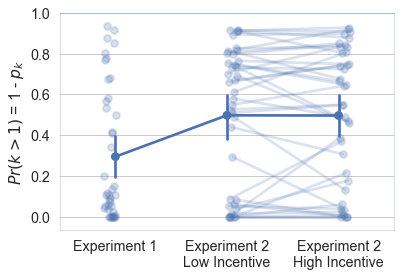

In [313]:
# Figure for the paper.

param = 'one_minus_geom_k_p'

f, ax = plt.subplots()
order = ['none', '1x', '3x']

alpha = 0.2
sns.pointplot(
    x='incentive',
    y=param,
    hue='pid',
    data=exp2_df, dodge=0.2,
    ax=ax,
    order=order,
)
# Mega hack
# https://github.com/mwaskom/seaborn/issues/979
new_color = tuple(sns.color_palette()[0]) + (alpha,)
for patch in ax.get_children():
    for n in ['facecolor', 'edgecolor', 'linecolor', 'color']:
        if not hasattr(patch, f'get_{n}'):
            continue
        c = getattr(patch, f'get_{n}')()
        if isinstance(c, str):
            continue
        if not isinstance(c, tuple) and len(c.shape) > 1:
            c = c[0, :]
        if len(c) == 4:
            r, g, b, _ = c
        else:
            r, g, b = c
        if (r, g, b) == (1, 1, 1):
            continue
        getattr(patch, f'set_{n}')(new_color)

# Also add summary
sns.pointplot(
    x='incentive', y=param,
    data=exp2_df,
    ax=ax,
    order=order,
)

ax.legend().remove()
ax.set_xticklabels(['Experiment 1', 'Experiment 2\nLow Incentive', 'Experiment 2\nHigh Incentive'])
ax.set_xlabel('')
ax.set_ylabel('$Pr(k > 1)$ = 1 - $p_k$')

plt.savefig('geom-k-p.pdf', bbox_inches='tight')


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

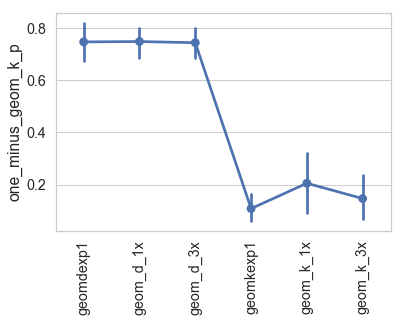

In [314]:
# Figure for the paper.

param = 'one_minus_geom_k_p'

f, ax = plt.subplots()
order = ['geomdexp1', 'geom_d_1x', 'geom_d_3x', 'geomkexp1', 'geom_k_1x', 'geom_k_3x']
#order = ['none', '1x', '3x']
'''
alpha = 0.2
sns.pointplot(
    x='labelx',
    y=param,
    hue='pid',
    data=exp2_df, dodge=0.2,
    ax=ax,
    order=order,
)
# Mega hack
# https://github.com/mwaskom/seaborn/issues/979
new_color = tuple(sns.color_palette()[0]) + (alpha,)
for patch in ax.get_children():
    for n in ['facecolor', 'edgecolor', 'linecolor', 'color']:
        if not hasattr(patch, f'get_{n}'):
            continue
        c = getattr(patch, f'get_{n}')()
        if isinstance(c, str):
            continue
        if not isinstance(c, tuple) and len(c.shape) > 1:
            c = c[0, :]
        if len(c) == 4:
            r, g, b, _ = c
        else:
            r, g, b = c
        if (r, g, b) == (1, 1, 1):
            continue
        getattr(patch, f'set_{n}')(new_color)
'''
# Also add summary
sns.pointplot(
    x='labelx',
    #x='incentive',
    y=param,
    #hue='pid',
    data=exp2_df,
    ax=ax,
    order=order,
)

ax.legend().remove()
#ax.set_xticklabels(['Experiment 1', 'Experiment 2\nLow Incentive', 'Experiment 2\nHigh Incentive'])
ax.set_xlabel('')
#ax.set_ylabel('$Pr(k > 1)$ = 1 - $p_k$')
plt.xticks(rotation=90)


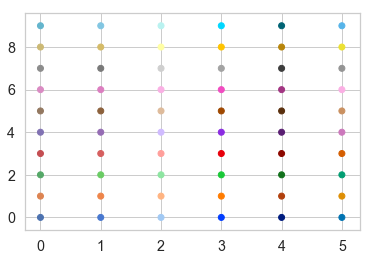

In [843]:
# lookin at colors

# HACK deep is the default template
for idx, pname in enumerate([
    'deep', 'muted', 'pastel', 'bright', 'dark', 'colorblind',
]):
    cp = sns.color_palette(pname)
    plt.scatter([idx] * len(cp), range(len(cp)), c=cp)

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


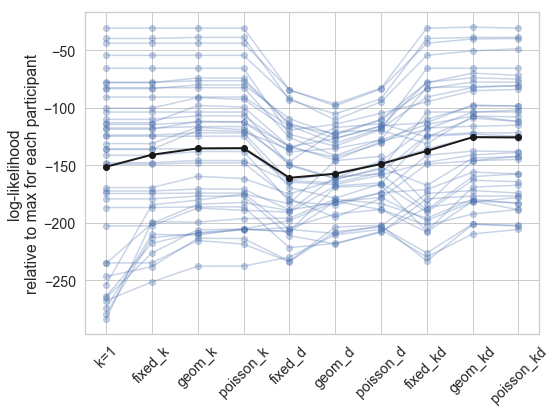

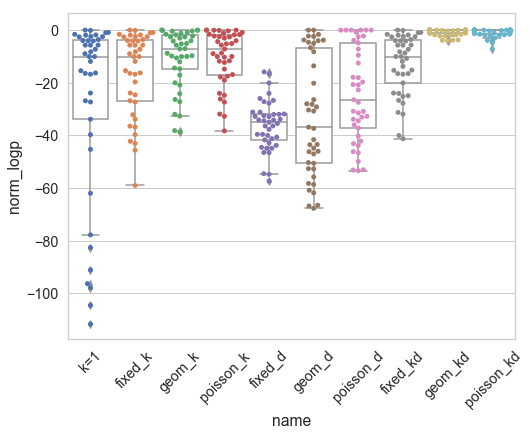

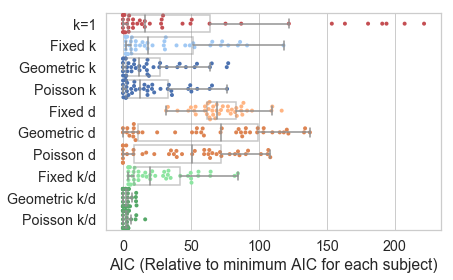

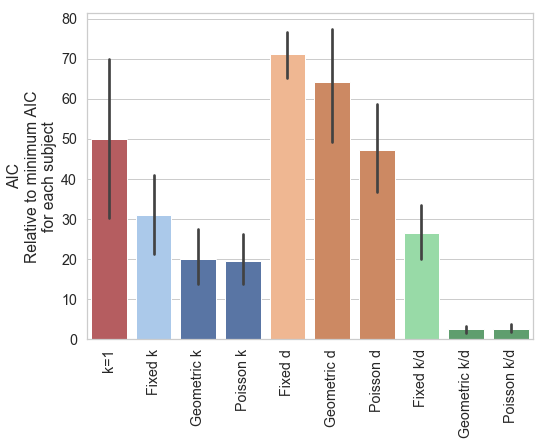

In [431]:
sns.set_style("whitegrid") 

f, ax = plt.subplots(figsize=(8, 6))

cp_dark = sns.color_palette('deep')
cp_light = sns.color_palette('pastel') # could do pastel instead
# Assumes the order of models as set in the for loop below during logp_df construction
colors = [
    cp_dark[3],
    cp_light[0],
    cp_dark[0],
    cp_light[1],
    cp_dark[1],
    cp_light[2],
    cp_dark[2],
]

model_name_to_param_count_hue = {
    # 1 param: p(err)
    'k=1': (1, 'k=1'),

    # 2 params: p(err), and model param (k/d for fixed, p for geom, rate for poisson)
    'fixed_k': (2, 'fixed_k'),
    'fixed_d': (2, 'fixed_d'),
    'geom_k': (2, 'k'),
    'geom_d': (2, 'd'),
    'poisson_k': (2, 'k'),
    'poisson_d': (2, 'd'),

    # 3 params: p(err), and n/p for binom
    'binom_k': (3, 'k'),
    'binom_d': (3, 'd'),

    # 3 params: p(err), k, d
    'fixed_kd': (3, 'fixed_kd'),
    'geom_kd': (3, 'kd'),
    'poisson_kd': (3, 'kd'),
}

model_name_to_label = {
    'k=1': 'k=1',
    'fixed_k': 'Fixed k',
    'geom_k': 'Geometric k',
    'binom_k': 'Binomial k',
    'poisson_k': 'Poisson k',
    'fixed_d': 'Fixed d',
    'geom_d': 'Geometric d',
    'binom_d': 'Binomial d',
    'poisson_d': 'Poisson d',
    'fixed_kd': 'Fixed k/d',
    'geom_kd': 'Geometric k/d',
    'poisson_kd': 'Poisson k/d',
}

logp_df = []

for pid, fits in exp1_pid_to_fit.items():

    # four models, (fixed, geom) * (k, depth)
    hi = [
        dict(name='k=1', logp=fits['k=1']['logp']),
        dict(name='fixed_k', logp=fits['fixed_k']['logp']),
        dict(name='geom_k', logp=fits['geom_k']['logp']),
#        dict(name='binom_k', logp=fits['binom_k']['logp']),
        dict(name='poisson_k', logp=fits['poisson_k']['logp']),
        dict(name='fixed_d', logp=fits['fixed_d']['logp']),
        dict(name='geom_d', logp=fits['geom_d']['logp']),
#        dict(name='binom_d', logp=fits['binom_d']['logp']),
        dict(name='poisson_d', logp=fits['poisson_d']['logp']),
        dict(name='fixed_kd', logp=fits['fixed_kd']['logp']),
        dict(name='geom_kd', logp=fits['geom_kd']['logp']),
        dict(name='poisson_kd', logp=fits['poisson_kd']['logp']),
    ]

    l = np.array([r['logp'] for r in hi])
    for item in hi:
        item['pid'] = pid
        param_count, hue = model_name_to_param_count_hue[item['name']]
        item['param_names'] = hue
        item['norm_logp'] = item['logp'] - np.max(l)
        item['aic'] = 2 * param_count - 2 * item['logp']
    aics = np.array([r['aic'] for r in hi])
    for item in hi:
        item['norm_aic'] = item['aic'] - np.min(aics)
    ax.plot([r['name'] for r in hi], [r['logp'] for r in hi], 'b-o', alpha=0.3)

    logp_df += hi

ax.set_ylabel('log-likelihood\nrelative to max for each participant')

logp_df = pd.DataFrame(logp_df)

x, y = zip(*[
    (name, logp_df.logp[logp_df.name==name].mean())
    for name in [item['name'] for item in hi]#, rows in logp_df.groupby('name')
])
#f, ax = plt.subplots(figsize=(9, 5))
ax.plot(x, y, 'k-o', lw=2)
ax.xaxis.set_tick_params(rotation=45)
#sns.lineplot(x='name', y='logp', data=logp_df, ax=ax)
plt.tight_layout()

f, ax = plt.subplots(figsize=(8, 6))
sns.swarmplot(x='name', y='norm_logp', data=logp_df, ax=ax)
sns.boxplot(x='name', y='norm_logp', data=logp_df, color='white', ax=ax)
ax.xaxis.set_tick_params(rotation=45)

def cm2inch(*args):
    return [v/2.54 for v in args]
'''

f, ax = plt.subplots(figsize=(6, 4))
sns.swarmplot(x='name', y='norm_aic', hue='param_names', dodge=False, data=logp_df, palette=colors, ax=ax)
sns.boxplot(x='name', y='norm_aic', hue='param_names', dodge=False, data=logp_df, color='white', ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.legend().remove()
axswarm = ax
'''

f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(
    y='name', x='norm_aic', hue='param_names',
    dodge=False, data=logp_df, color=[1, 1, 1, 0],
    ax=ax, orient='h', showfliers=False,

    boxprops={"zorder":10},
    whiskerprops={"zorder":10},
    zorder=10,
)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))
    r, g, b, a = patch.get_edgecolor()
    patch.set_edgecolor((r, g, b, 0.5))
sns.swarmplot(
    y='name', x='norm_aic', hue='param_names', dodge=False,
    data=logp_df, palette=colors, ax=ax, orient='h', size=4)
#ax.xaxis.set_tick_params(rotation=90)
ax.legend().remove()
ax.set_ylabel('')
ax.set_xlabel('AIC (Relative to minimum AIC for each subject)')
ax.set_yticklabels([model_name_to_label[item['name']] for item in hi])
axswarm = ax

f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='name', y='norm_aic', hue='param_names', dodge=False, data=logp_df, palette=colors, ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.legend().remove()

ax.set_xlabel('')
ax.set_ylabel('AIC\nRelative to minimum AIC\nfor each subject')
ax.set_xticklabels([model_name_to_label[item['name']] for item in hi])

plt.sca(axswarm)
plt.savefig('model-fits.eps', bbox_inches='tight')

In [432]:
from collections import Counter
pivot_df_aic = logp_df[['pid', 'aic', 'name']].pivot('pid', 'name', 'aic')
pivot_df_logp = logp_df[['pid', 'logp', 'name']].pivot('pid', 'name', 'logp')
all_models = set(logp_df.name.unique())
def _compare_models(main, *alternatives_raw):
    # HACK
    # HACK
    # HACK
    alternatives = tuple(set(alternatives_raw) - {'binom_d', 'binom_k'})
    # HACK
    # HACK
    # HACK
    print(f'AIC {main} {pivot_df_aic[main].sum():.01f}')
    alt_aic = [pivot_df_aic[alt].sum() for alt in alternatives]
    maxidx = np.argmin(alt_aic)
    print(f'AIC best alt {alternatives[maxidx]} {alt_aic[maxidx]:.01f}')
    print(f'AIC alternatives: {[(alt, "{:.01f}".format(aic)) for alt, aic in zip(alternatives, alt_aic)]}')

    ct_better = 0
    ct_best = Counter()
    for _, row in pivot_df_aic.iterrows():
        if all(
            row[main] < row[alt]
            for alt in alternatives
        ):
            ct_better += 1
        ct_best[min((main,) + alternatives, key=lambda name: row[name])] += 1
    print(f'{ct_better} out of {pivot_df_aic.shape[0]} participants')
    print('Max counts', [(name, ct) for name, ct in sorted(ct_best.items(), key=lambda pair: -pair[-1])])
    # Take max logp of other models.
    print()

_compare_models('k=1', 'fixed_d', 'geom_d', 'binom_d', 'poisson_d')

_compare_models('geom_k', 'fixed_d', 'geom_d', 'binom_d', 'poisson_d')
_compare_models('geom_kd', *list(all_models-{'geom_kd'}))

_compare_models('geom_k', 'fixed_k')
_compare_models('geom_d', 'fixed_d')

# Makin a table!

model_names = list(logp_df.name.unique())
print(model_names)
from collections import Counter
best_ct = Counter()
for _, row in pivot_df_aic.iterrows():
    best_model = min(model_names, key=lambda name: row[name])
    best_ct[best_model] += 1

r = []
for model_name in logp_df.name.unique():
    aic = pivot_df_aic[model_name].sum()
    ll = pivot_df_logp[model_name].sum()
    param_count, hue = model_name_to_param_count_hue[model_name]
    # HACK add # part best fit
    num_participants = best_ct[model_name]
    r.append(dict(
        label=model_name_to_label[model_name],
        aic=int(aic),
        ll=int(ll),
        param_count=param_count,
        num_participants=num_participants))

def _make_params_look_nice(name):
    name = re.sub(r'\bd\b', '$d$', name)
    name = re.sub(r'\bk\b', '$k$', name)
    return name
for idx, row in enumerate(sorted(r, key=lambda row: row['aic'])):
    if idx == 0:
        row = dict(row, aic='\\textbf{' + str(row['aic']) + '}')
    row = dict(row, label=_make_params_look_nice(row['label']))
    print('{label} & {param_count} & {aic} & {ll} & {num_participants} \\\\'.format(**row))

AIC k=1 12482.7
AIC best alt poisson_d 12364.2
AIC alternatives: [('fixed_d', '13348.5'), ('geom_d', '13062.6'), ('poisson_d', '12364.2')]
27 out of 41 participants
Max counts [('k=1', 27), ('poisson_d', 12), ('geom_d', 2)]

AIC geom_k 11250.0
AIC best alt poisson_d 12364.2
AIC alternatives: [('fixed_d', '13348.5'), ('geom_d', '13062.6'), ('poisson_d', '12364.2')]
28 out of 41 participants
Max counts [('geom_k', 28), ('poisson_d', 11), ('geom_d', 2)]

AIC geom_kd 10533.2
AIC best alt poisson_kd 10541.8
AIC alternatives: [('fixed_k', '11705.7'), ('poisson_k', '11234.4'), ('fixed_d', '13348.5'), ('k=1', '12482.7'), ('poisson_kd', '10541.8'), ('fixed_kd', '11518.7'), ('poisson_d', '12364.2'), ('geom_k', '11250.0'), ('geom_d', '13062.6')]
12 out of 41 participants
Max counts [('geom_kd', 12), ('poisson_kd', 10), ('poisson_d', 7), ('k=1', 6), ('geom_k', 2), ('geom_d', 2), ('poisson_k', 2)]

AIC geom_k 11250.0
AIC best alt fixed_k 11705.7
AIC alternatives: [('fixed_k', '11705.7')]
32 out of 

In [434]:
# How many subjects are k=1?

thresh = 0.95

k1 = sum(
    1
    for pid, fits in exp1_pid_to_fit.items()
    if fits['geom_k']['p'] > thresh
)
print(f'{k1} subjects out of {len(exp1_pid_to_fit)} are k=1')

12 subjects out of 41 are k=1


In [133]:
# Comparing new model fits to old
for _ in range(3):
    pid = list(model_inputs.keys())[1]#'k=2a'
    print('pid', pid)

    arbitrary_state = problems_to_analyze[0]
    arbitrary_problem = blockworld.Blockworld(arbitrary_state, model.make_goals(arbitrary_state))

    i = model_inputs[pid]
    fits = _fit_models(arbitrary_problem, agent_names, i['model_p'], i['rand_p'], random_x0=True)
    for name, fit in fits.items():
        if 'k=' in name and 'd=' in name:
            continue
        print(name, fit)
    print()

# Now sanity checking against old code...
for agent_idx in [agent_names.index(f'k={k}') for k in range(1, 6)]:
    name, _ = agents[agent_idx]
    if 'k=' in name and 'd=' in name:
        continue
    print(name, model.fit_epsilon_greedy_model(i['model_p'][agent_idx, :], i['rand_p']))

pid 4
k=1 {'p_err': 0.145522092872303, 'logp': -174.42237225190672}
k=2 {'p_err': 0.2690703687380638, 'logp': -255.31214575774788}
k=3 {'p_err': 0.2598894653540579, 'logp': -247.9466693086645}
k=4 {'p_err': 0.2832517190550422, 'logp': -256.37778695438}
k=5 {'p_err': 0.3254204593379348, 'logp': -271.8957217129034}
k=6 {'p_err': 0.33202088496857446, 'logp': -272.7520512668316}
d=1 {'p_err': 0.07897227880215907, 'logp': -302.12413500642106}
d=2 {'p_err': 0.10453389391705308, 'logp': -246.3575669302349}
d=3 {'p_err': 0.1061518670179618, 'logp': -205.70248352900018}
d=4 {'p_err': 0.17664006502358506, 'logp': -230.81819373519215}
d=5 {'p_err': 0.1568028763274169, 'logp': -212.4806317371219}
d=6 {'p_err': 0.1916549763182511, 'logp': -246.32280848441218}
d=7 {'p_err': 0.22466270822791684, 'logp': -248.05270593635979}
d=8 {'p_err': 0.2522084630791387, 'logp': -251.66053881852255}
d=9 {'p_err': 0.2709277643921305, 'logp': -256.04587318969277}
d=10 {'p_err': 0.2627874571487119, 'logp': -253.39013

/Users/carlos/pu/multigoals/analysis/model.py:23: RuntimeWarning: divide by zero encountered in log
  logp = np.log(noisy_model_p(p_err))


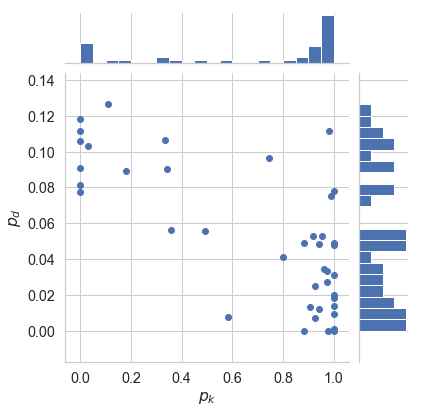

In [484]:
# How many people are k > 1?

# identify those better geom than depth model, to color differently

def _expected_geom_value(geom_p, vals):
    ps = _truncated_discrete_dist(geom(geom_p), vals)
    return (ps * vals).sum()

logp_df = []

for pid, fits in exp1_pid_to_fit.items():
    logp_df.append(
        dict(
            one_minus_geom_k_p=1-fits['geom_k']['p'],
            one_minus_geom_kd_pk=1-fits['geom_kd']['p_k'],
            one_minus_geom_kd_pd=1-fits['geom_kd']['p_depth'],
            geom_k_p=fits['geom_k']['p'],
            geom_kd_pk=fits['geom_kd']['p_k'],
            geom_kd_pd=fits['geom_kd']['p_depth'],
            geom_k_p_err=fits['geom_k']['p_err'],
            name='',
            geom_k_better=fits['geom_k']['logp'] > fits['geom_d']['logp'],
            geom_k_logp_diff=fits['geom_k']['logp'] - fits['geom_d']['logp'],
        )
    )

logp_df = pd.DataFrame(logp_df)

#f, ax = plt.subplots()
#ax.hist(logp_df.one_minus_geom_kd_pk, bins=np.arange(0, 1.01, 0.05))
'''
g = sns.jointplot(
    x='one_minus_geom_kd_pk',
    y='one_minus_geom_kd_pd',
    data=logp_df,
    marginal_kws=dict(),#bins=np.arange(0, 1.01, 0.05)))
)'''

g = sns.JointGrid(x="geom_kd_pk", y="geom_kd_pd", data=logp_df)
g = g.plot_joint(
    plt.scatter,
    #color="m",
    #edgecolor="white",
)

#g.ax_marg_x.hist(tips["total_bill"], color="b", alpha=.6,
#...                      bins=np.arange(0, 60, 5))
g.ax_marg_x.hist(logp_df['geom_kd_pk'], bins=np.arange(0, 1.01, 0.05))
g.ax_marg_y.hist(
    logp_df['geom_kd_pd'],
    orientation="horizontal",
    bins=20)

#ax.legend().remove()
#ax.set_xticklabels(['Experiment 1', 'Experiment 2\nLow Incentive', 'Experiment 2\nHigh Incentive'])
#plt.xlabel('$Pr(k > 1)$ = 1 - $p_k$')
plt.xlabel('$p_k$')
#plt.ylabel('$Pr(d > 1)$ = 1 - $p_d$')
plt.ylabel('$p_d$')

plt.savefig('geom-k-p.pdf', bbox_inches='tight')


'''
f, ax = plt.subplots()#1, 2, figsize=(12, 4))
sns.boxplot(y='name', x='expected_k', orient='h', data=logp_df, color='white', ax=ax, width=0.4)
g = sns.swarmplot(y='name', x='expected_k', hue='geom_k_better', orient='h', data=logp_df, ax=ax)
ax.set_title('Parameter $p$ for Geometric distribution over $k$')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend([
    g.get_children()[1],
    g.get_children()[2],
], [
    'Best fit is Geometric depth',
    'Best fit is Geometric k',
], loc='lower left')

plt.tight_layout()

plt.savefig('geom-k-p.eps', bbox_inches='tight')

#f, ax = plt.subplots()
#ax.plot(logp_df.geom_k_p, logp_df.geom_k_p_err, '.')
'''
None

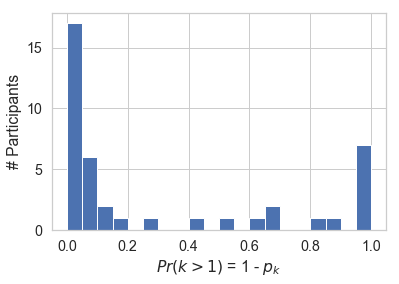

In [489]:
# How many people are k > 1?

# identify those better geom than depth model, to color differently

def _expected_geom_value(geom_p, vals):
    ps = _truncated_discrete_dist(geom(geom_p), vals)
    return (ps * vals).sum()

logp_df = []

for pid, fits in exp1_pid_to_fit.items():
    logp_df.append(
        dict(
            one_minus_geom_k_p=1-fits['geom_k']['p'],
            one_minus_geom_kd_pk=1-fits['geom_kd']['p_k'],
            one_minus_geom_kd_pd=1-fits['geom_kd']['p_depth'],
            geom_k_p=fits['geom_k']['p'],
            geom_kd_pk=fits['geom_kd']['p_k'],
            geom_kd_pd=fits['geom_kd']['p_depth'],
            geom_k_p_err=fits['geom_k']['p_err'],
            name='',
            geom_k_better=fits['geom_k']['logp'] > fits['geom_d']['logp'],
            geom_k_logp_diff=fits['geom_k']['logp'] - fits['geom_d']['logp'],
        )
    )

logp_df = pd.DataFrame(logp_df)

f, ax = plt.subplots()
ax.hist(logp_df.one_minus_geom_kd_pk, bins=np.arange(0, 1.01, 0.05))

#ax.legend().remove()
#ax.set_xticklabels(['Experiment 1', 'Experiment 2\nLow Incentive', 'Experiment 2\nHigh Incentive'])
plt.xlabel('$Pr(k > 1)$ = 1 - $p_k$')
plt.ylabel('# Participants')

plt.savefig('geom-k-p.pdf', bbox_inches='tight')

None

Text(0, 0.5, 'Expected k')

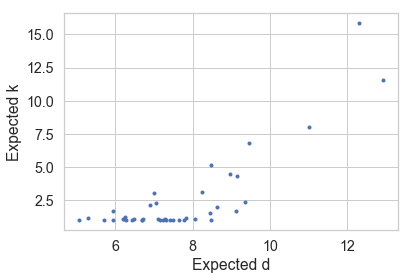

In [240]:
plt.plot(logp_df.expected_d, logp_df.expected_k, '.')
plt.xlabel('Expected d')
plt.ylabel('Expected k')

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Counts of models with max logp:
	geom_kd: 27
	geom_depth: 6
	k=1: 1
	geom: 1

Top 10 estimates of p for geom: [0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.9938053678546337, 0.9928259853851243, 0.9776278491094201, 0.9610442164375026, 0.9551983597767265]
sum(logp) for geom: -4871.238419191106

Top 10 estimates of p for geom_depth: [0.19483312489061605, 0.17375517263219997, 0.16762026790984325, 0.16681995039352276, 0.15566418565163057, 0.15513936849961169, 0.1532879327696375, 0.15125601361776542, 0.1506208150026058, 0.1506107274248907]
sum(logp) for geom_depth: -5565.05591833378

sum(logp) for geom_kd: -4504.715457558663


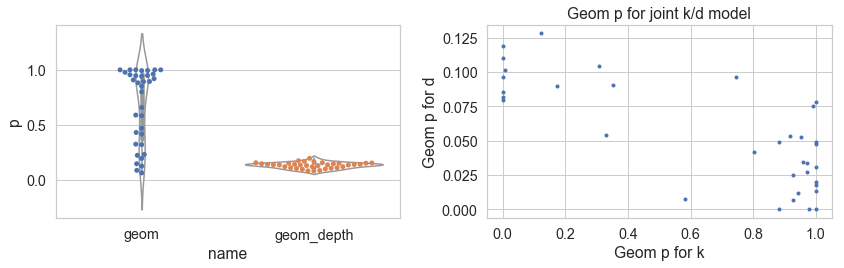

In [285]:
logp_df = []
from collections import Counter
max_ct = Counter()

for pid in curr_df.pid.unique():
    fits = pid_to_fit[pid]
    logp_df += [
        dict(p=fits[name]['p'], logp=fits[name]['logp'], name=name)
        for name in ['geom_k', 'geom_d']
    ]
    keys = [k for k in fits.keys() if k != 'geom_kd']
    keys = fits.keys()
    max_key = max(keys, key=lambda k: fits[k]['logp'])
    max_ct[max_key] += 1

logp_df = pd.DataFrame(logp_df)

f, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.violinplot(x='name', y='p', data=logp_df, color='white', ax=ax)
sns.swarmplot(x='name', y='p', data=logp_df, ax=ax)

print('Counts of models with max logp:')
for k, ct in sorted(max_ct.items(), key=lambda pair: pair[-1], reverse=True):
    print(f'\t{k}: {ct}')
print()

for name, rows in logp_df.groupby('name'):
    print(f'Top 10 estimates of p for {name}: {sorted(rows.p.values, reverse=True)[:10]}')
    print(f'sum(logp) for {name}: {rows.logp.sum()}')
    print()

for name in ['geom_kd']:
    l = [pid_to_fit[pid][name]['logp'] for pid in curr_df.pid.unique()]
    print(f'sum(logp) for {name}: {np.sum(l)}')

ax2.set_title('Geom p for joint k/d model')
ax2.set_xlabel('Geom p for k')
ax2.set_ylabel('Geom p for d')
ax2.plot(
    [pid_to_fit[pid]['geom_kd']['p_k'] for pid in curr_df.pid.unique()],
    [pid_to_fit[pid]['geom_kd']['p_depth'] for pid in curr_df.pid.unique()], '.')

plt.tight_layout()

In [56]:
# Comparing new model fits to old

for pid in curr_df.pid.unique():
    print('pid', pid)
    i = model_inputs[pid]
    fits = _fit_models(arbitrary_problem, agent_names, i['model_p'], i['rand_p'])
    print('\t', 'geom_k', fits['geom_k'])
    other_max_fit_k = max([k for k in fits.keys() if k != 'geom_k'], key=lambda k: fits[k]['logp'])
    print('\t', 'next best fit:', other_max_fit_k, fits[other_max_fit_k])

pid 1
	 geom {'p': 0.5687475607769119, 'p_err': 0.15655588142279764, 'logp': -133.90925810109596}
	 next best fit: geom_depth {'p': 0.20530884851206993, 'p_err': 0.01327491182794864, 'logp': -123.67903471838532}
pid 2
	 geom {'p': 0.21908381098253865, 'p_err': 0.08190957961839689, 'logp': -74.76137158094168}
	 next best fit: geom_depth {'p': 0.08517012250933728, 'p_err': 1e-08, 'logp': -60.250918905430964}
pid 3
	 geom {'p': 0.4457164199717974, 'p_err': 0.17537701968050315, 'logp': -152.53269379904816}
	 next best fit: geom_depth {'p': 0.19282849051612636, 'p_err': 0.040094944119571735, 'logp': -144.26649902344997}
pid 0
	 geom {'p': 0.556492169302376, 'p_err': 0.18647637727691002, 'logp': -151.4958307440361}
	 next best fit: geom_depth {'p': 0.2128728262134545, 'p_err': 0.035431804145145546, 'logp': -140.46013961505122}
